In [2]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


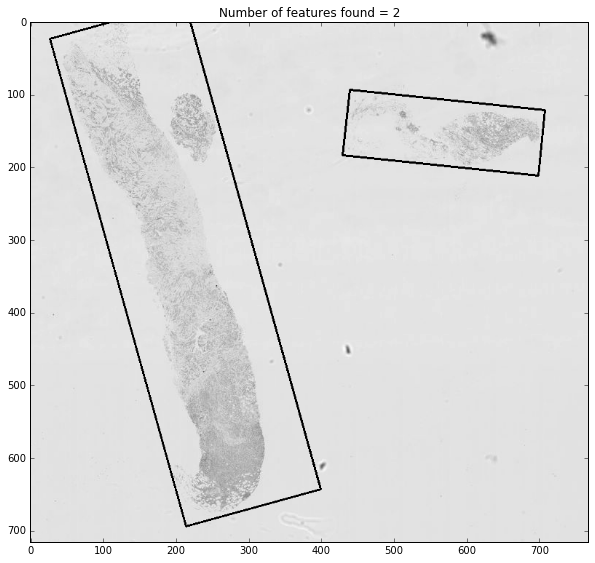

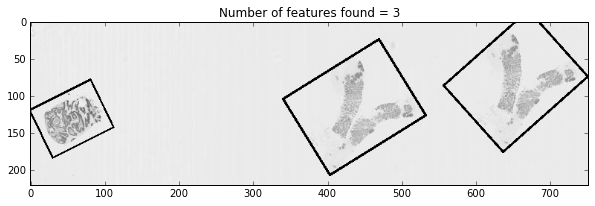

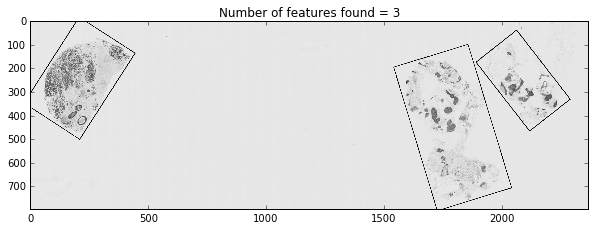

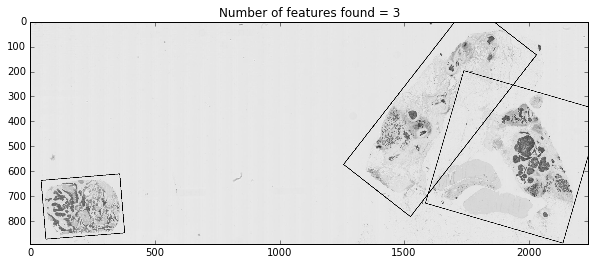

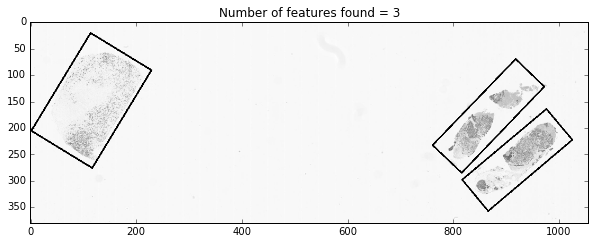

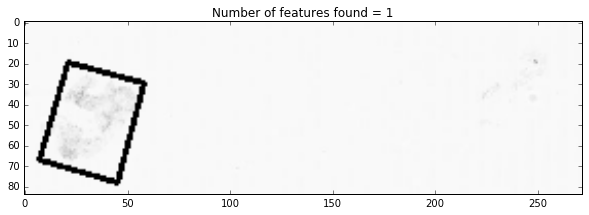

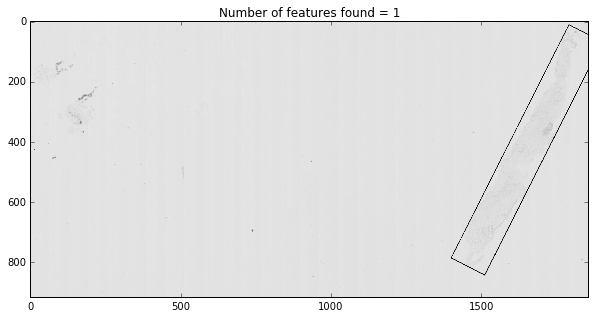

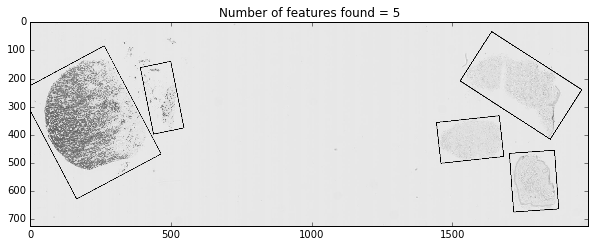

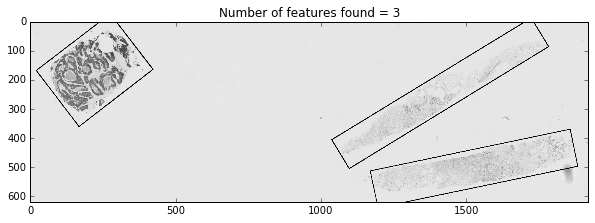

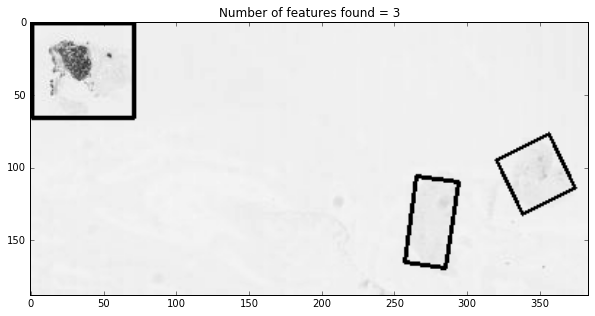

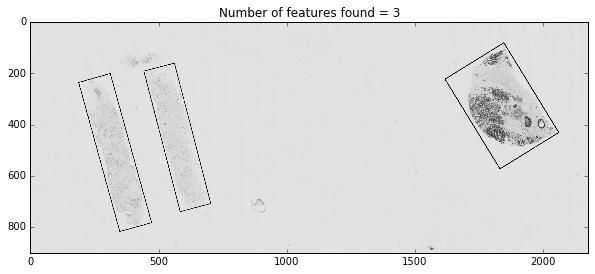

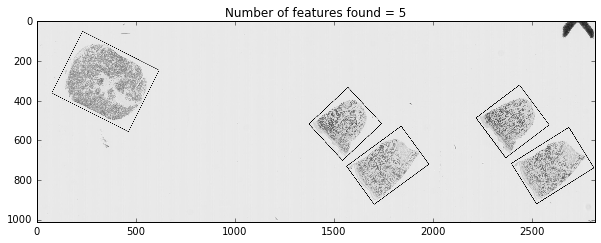

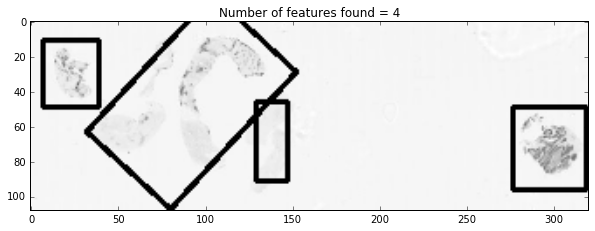

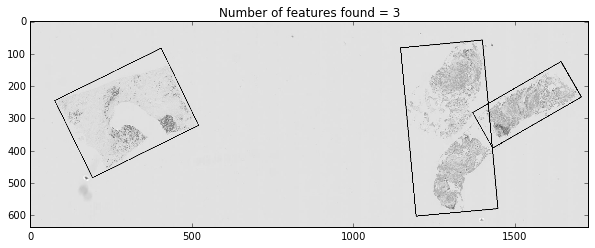

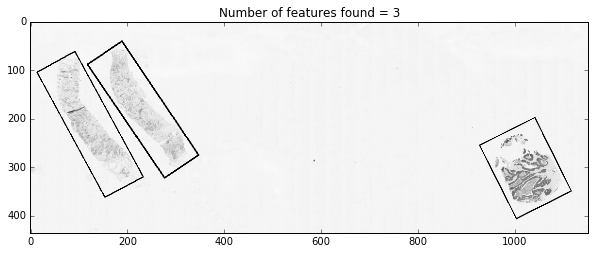

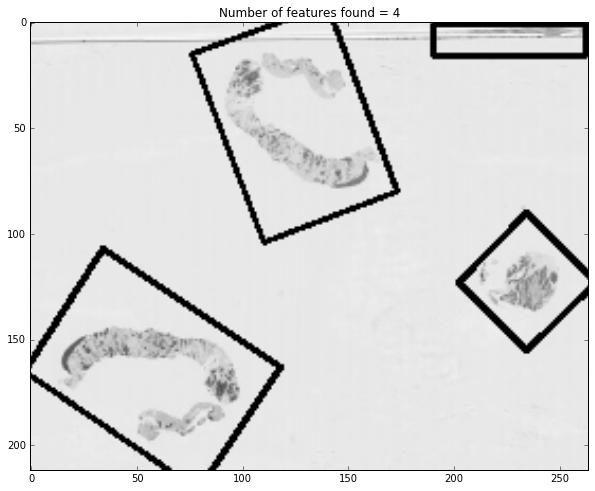

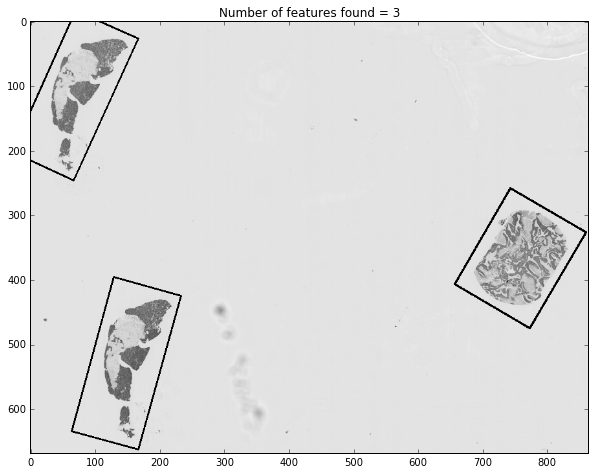

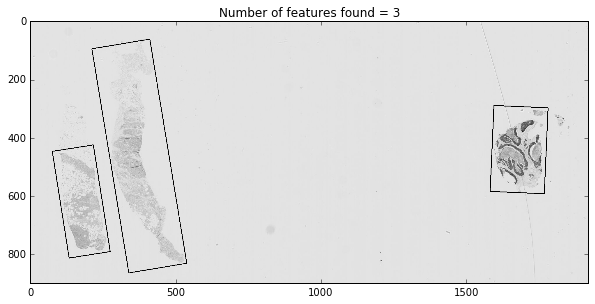

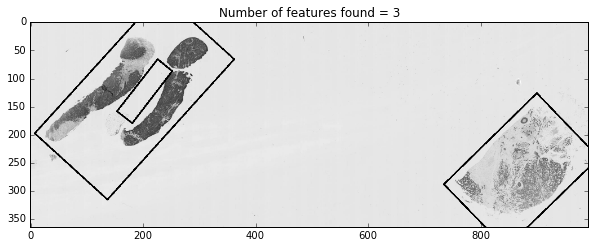

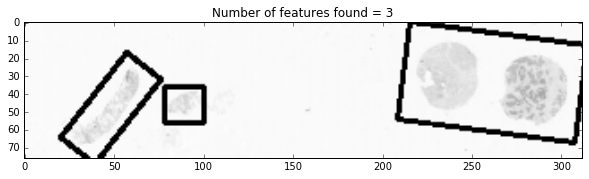

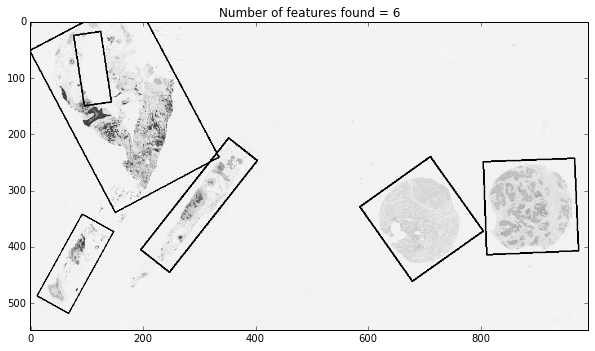

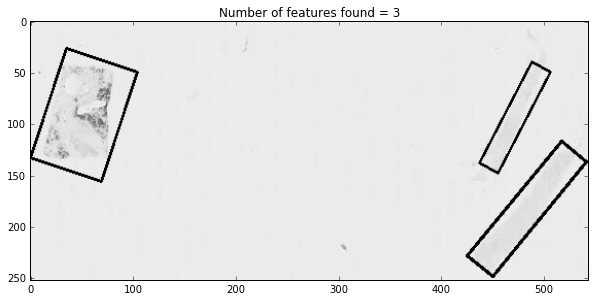

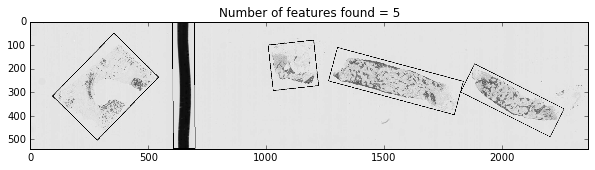

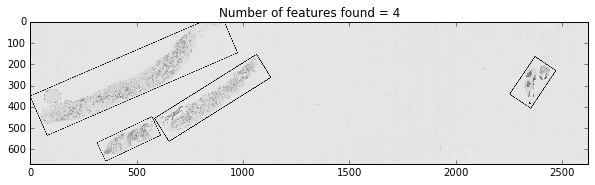

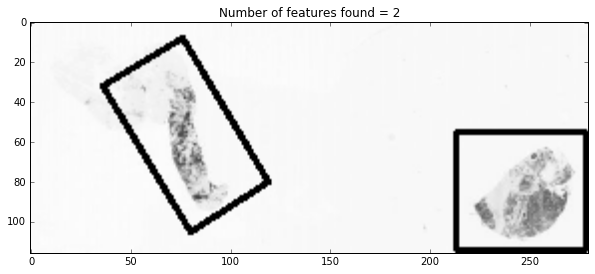

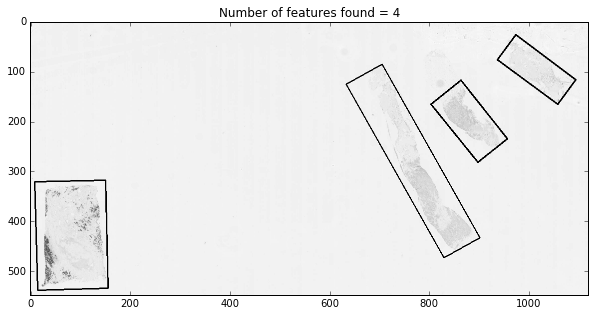

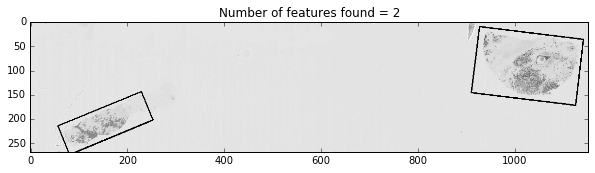

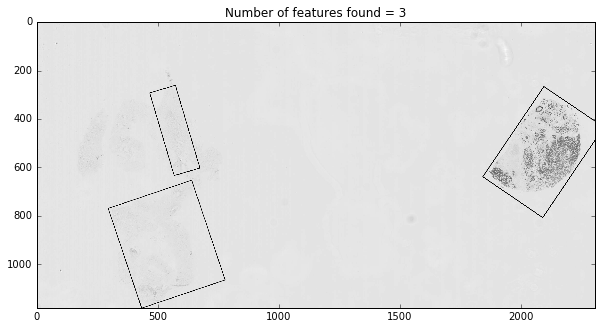

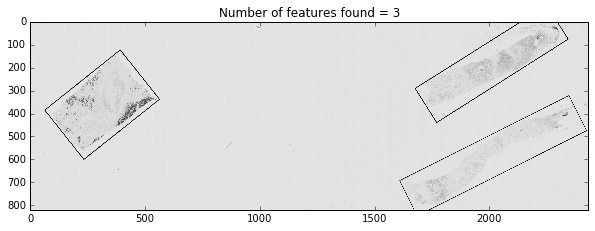

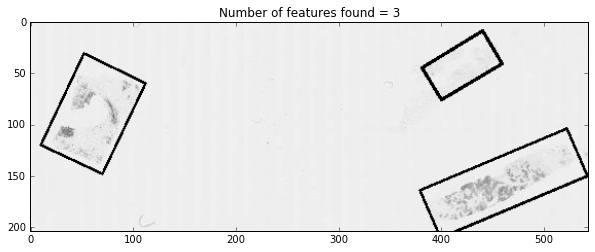

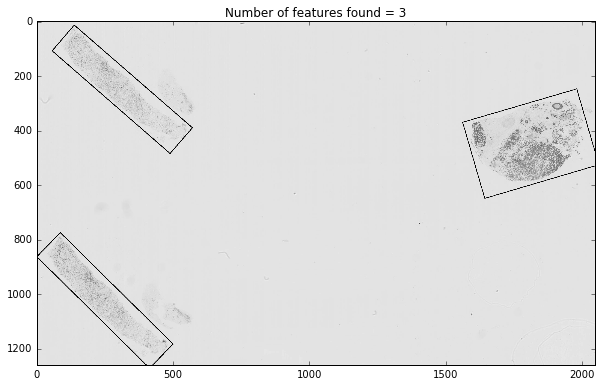

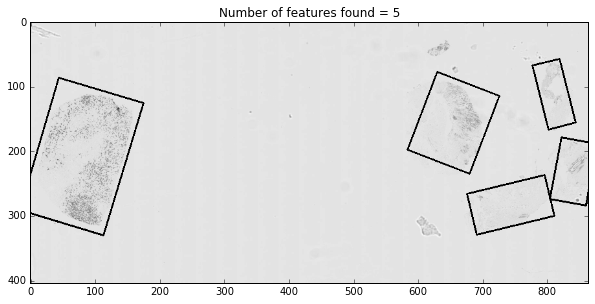

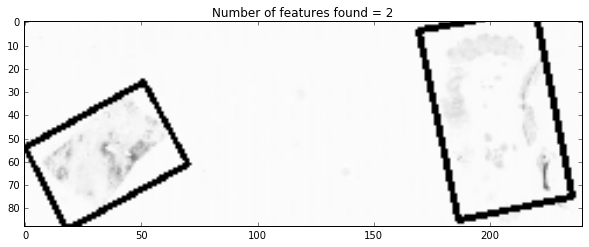

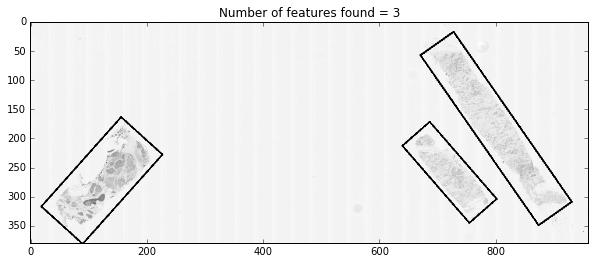

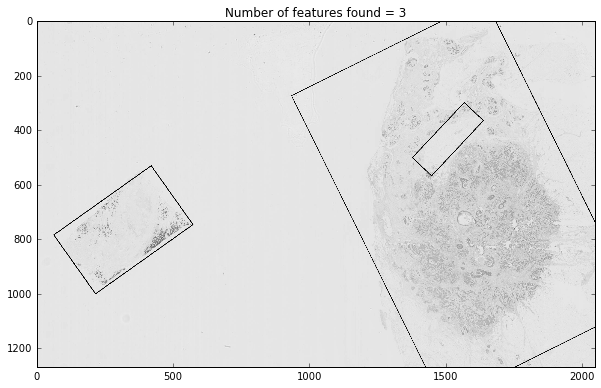

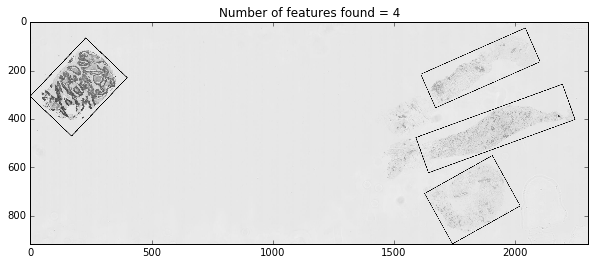

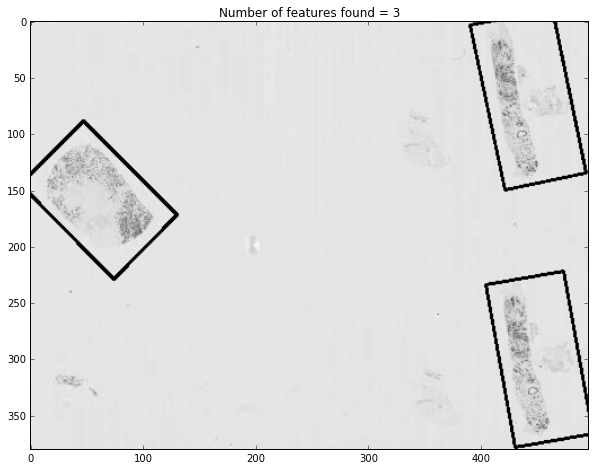

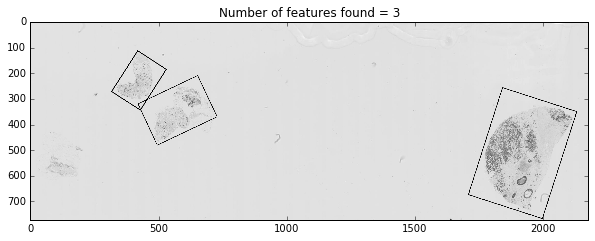

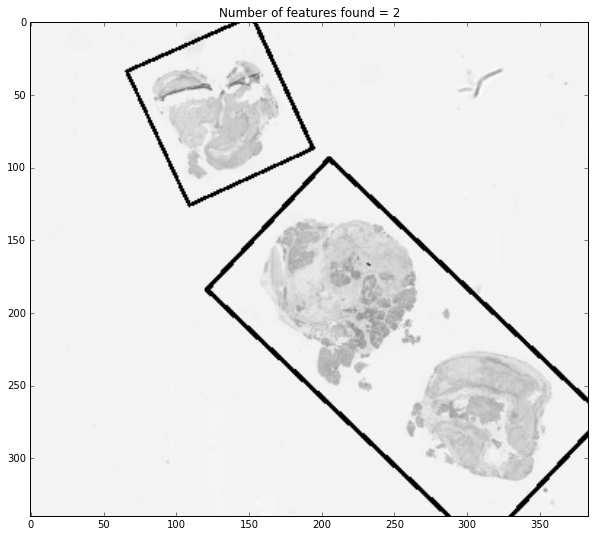

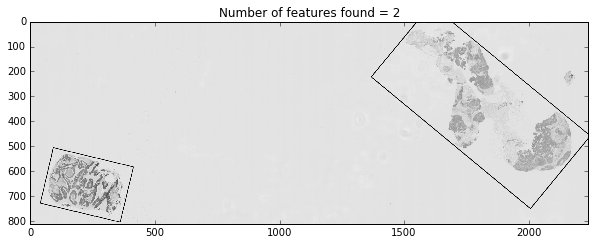

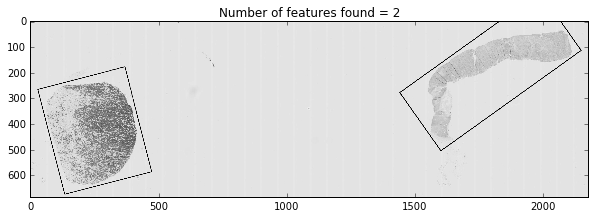

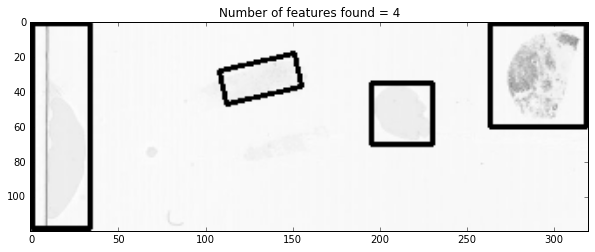

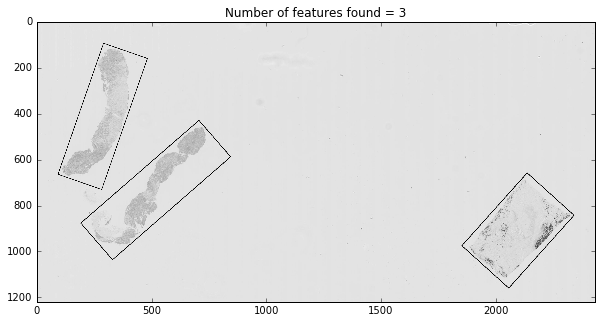

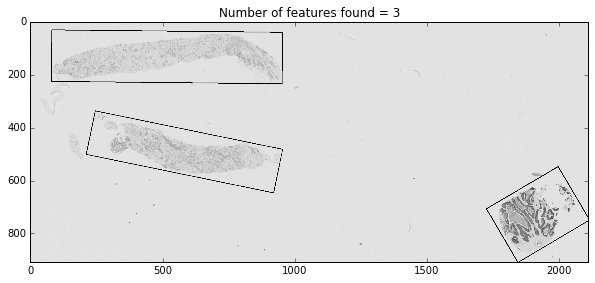

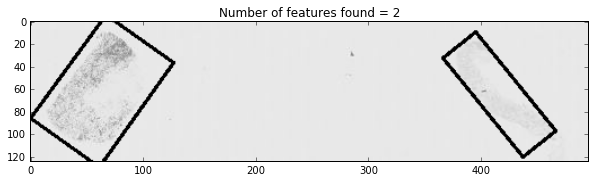

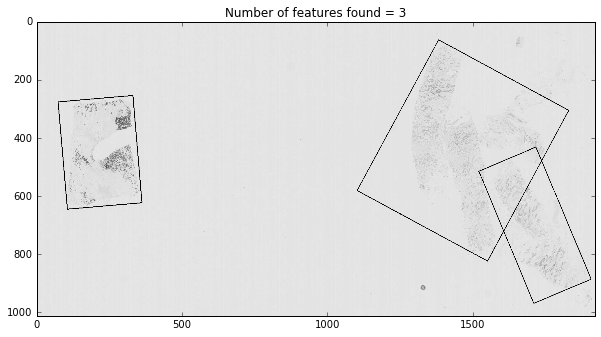

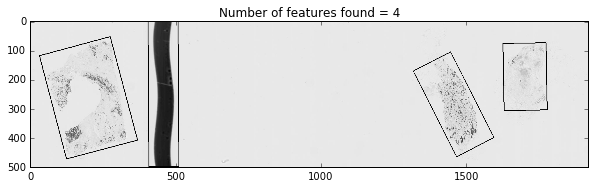

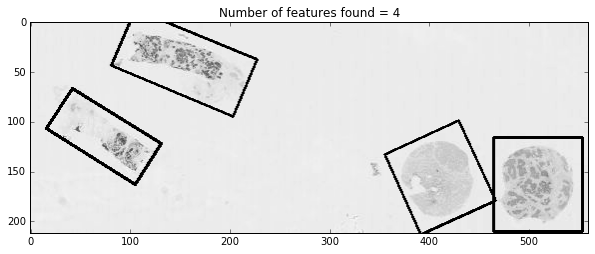

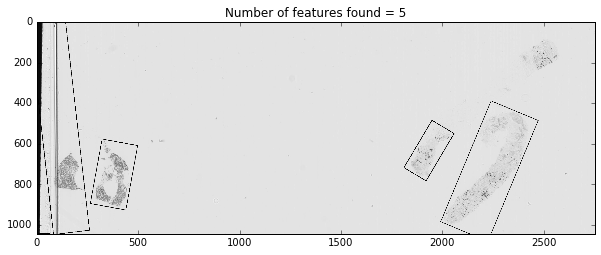

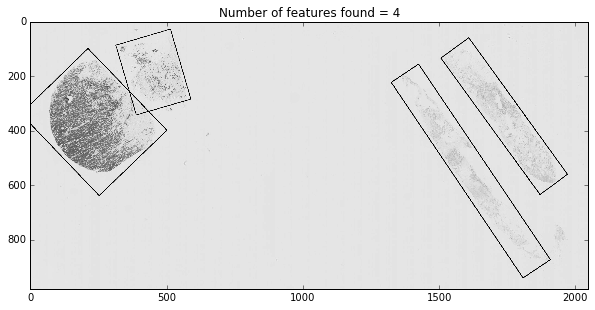

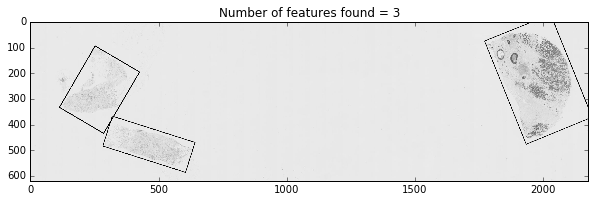

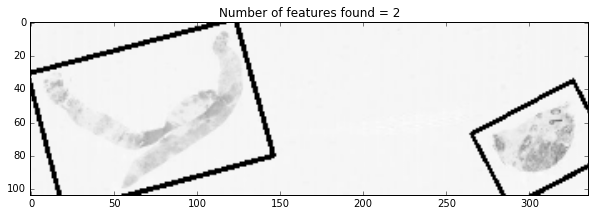

In [47]:
groundTruth = pd.read_csv("data/groundTruth.csv")
class her2Image():
    def __init__(self,caseNumber):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
        self.lowResDims = self.her2.level_dimensions[-3] #3 is arbitrary but works
        lowRes = np.asarray(self.her2.read_region((0,0),self.nLevels-3,(self.lowResDims[0],self.lowResDims[1]))) 
        self.lowRes = cv2.cvtColor(lowRes, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
    def show(self):
        plt.imshow(self.lowRes,cm.gray)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        
    def featureShow(self):
        img = cv2.GaussianBlur(self.lowRes,(47,47),0)
        ret,thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-4,255,1)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        self.featureCount = 0
        for cnt in contours:

            #cnt = contours[0]
            M = cv2.moments(cnt)

            rect = cv2.minAreaRect(cnt)
            area = reduce(mul,rect[1])
            if area > self.lowResArea*0.01:
                self.featureCount += 1
                box = cv2.cv.BoxPoints(rect)
                box = np.int0(box)
                cv2.drawContours(self.lowRes,[box],0,(0,255,255),2)
        plt.figure(figsize=(10,10))
        plt.imshow(self.lowRes,cmap=cm.gray)
        plt.title("Number of features found = %d" % self.featureCount)
        plt.show()
    
for i in groundTruth.CaseNo.values[:]:
    eg = her2Image(i)
    eg.featureShow()